## Import sample data for exploratory analysis

In [17]:
import pandas as pd
df = pd.read_csv('chatgpt_reviews_sample.csv')

In [18]:
# Converting 'at' column to datetime format
df['at'] = pd.to_datetime(df['at'])
df['at'].head()

0   2025-07-05 10:41:53
1   2025-06-25 14:31:34
2   2025-03-29 12:40:17
3   2025-06-24 03:40:27
4   2025-07-07 09:52:25
Name: at, dtype: datetime64[ns]

In [19]:
import pandas as pd
from langdetect import detect, LangDetectException
import matplotlib.pyplot as plt

# Drop rows with no text content to avoid errors
df.dropna(subset=['content'], inplace=True)

# Function to detect language safely
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Apply the function to create the 'language' column
print("Detecting languages... This may take a moment.")
df['language'] = df['content'].apply(detect_language)

# --- 1. Process Data for the Pie Chart ---

# Get the counts of each language
lang_counts = df['language'].value_counts()

# Define how many top languages to show separately
top_n = 6
# Create a new Series for the chart data
pie_data = lang_counts.head(top_n).copy()
# Sum the counts of all other languages
other_count = lang_counts.iloc[top_n:].sum()

# Add the 'Other' category if there are more languages than top_n
if len(lang_counts) > top_n:
    pie_data['Other'] = other_count


Detecting languages... This may take a moment.


In [20]:
# 2. IMPORTANT: Filter for English reviews FIRST
df_english = df[df['language'] == 'en'].copy()
df_english['reviews_word_count']=df_english['content'].str.split().map(len)

In [21]:
import importlib
import utils  # Make sure your module is imported

# This is the key line that reloads the module from your saved file
importlib.reload(utils)

# After reloading, you can import your specific function again to ensure you're using the latest version
from utils import preprocess_for_lda

print("utils.py module has been reloaded with the latest changes.")

utils.py module has been reloaded with the latest changes.


## Pain Point Analysis

In [22]:
negative_df=df_english[df_english['score']<=2].copy()
print(f"Analyzing {len(negative_df)} negative reviews.")


Analyzing 463 negative reviews.


In [23]:
import re
import nltk
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from utils import preprocess_for_lda

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

corpus = preprocess_for_lda(negative_df['content']) # Using the sample for this example
corpus = [doc for doc in corpus if doc]

# --- 3. Train LDA Model on Negative Reviews ---
if corpus:
    dic = Dictionary(corpus)
    dic.filter_extremes(no_below=5, no_above=0.6) # Adjust filtering for a smaller dataset
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    # Look for 5 distinct pain point topics
    lda_model_negative = LdaMulticore(
        bow_corpus,
        num_topics=5,
        id2word=dic,
        passes=15,
        workers=2,
        random_state=42
    )

    # --- 4. Display the Pain Point Topics ---
    print("\n--- Top 5 User Pain Point Topics ---")
    topics = lda_model_negative.show_topics(num_words=8)
    for topic_id, topic_words in topics:
        print(f"Topic {topic_id + 1}: {topic_words}")
else:
    print("Corpus of negative reviews is empty after preprocessing. Cannot train model.")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m1391\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\m1391\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m1391\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\m1391\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



--- Top 5 User Pain Point Topics ---
Topic 1: 0.056*"answer" + 0.039*"pay" + 0.033*"question" + 0.032*"like" + 0.029*"paid" + 0.027*"response" + 0.026*"wrong" + 0.026*"ask"
Topic 2: 0.052*"please" + 0.052*"time" + 0.040*"update" + 0.032*"phone" + 0.030*"application" + 0.029*"error" + 0.026*"hate" + 0.026*"new"
Topic 3: 0.037*"information" + 0.035*"keep" + 0.033*"slow" + 0.030*"know" + 0.029*"wrong" + 0.029*"voice" + 0.028*"asked" + 0.027*"language"
Topic 4: 0.039*"image" + 0.030*"photo" + 0.027*"able" + 0.027*"one" + 0.025*"take" + 0.025*"login" + 0.024*"time" + 0.023*"problem"
Topic 5: 0.070*"time" + 0.043*"something" + 0.036*"always" + 0.031*"wrong" + 0.030*"like" + 0.027*"one" + 0.027*"showing" + 0.024*"answer"



Observation:

    Pain Point 1: Performance/Slowness Issues

        Users complain that the app is slow or has performance issues. 

        Actionable Insight: This is direct feedback for the app development team to prioritize performance optimization. An investigation should focus on reducing app startup time and response latency.

    Pain Point 2: Login/Phone Version Issues

        Interpretation: Users complain about the persistent problem with logging in, potentially on phone versions of the app

        Actionable Insight: This points to a critical-path issue blocking user access. The development team should review the mobile authentication flow, investigating session management and third-party login integrations (like Google Sign-In) to reduce login failures.

    Pain Point 3: Additional Capabilities Issues

        
        Interpretation: Users complain about the app's weakness in processing or generating content through non-text media such as images, photos or audio.

        Actionable Insight: This provides feedback for future product development. The product and R&D teams should evaluate the performance and reliability of the voice and image features. 

    Pain Point 5: Accuracy Issues


        Interpretation: Users complain about the inaccuracy or the existence of errors in the AI's generated answers.

        Actionable Insight: This offers feedback on the core AI model's quality. The AI/ML team should track the cases of such complaints with past updates to better understand the progress in model fine-tuning.

    Pain Point 4: Update-related Issues


        Interpretation: Users complain that the app has become worse or doesn't work since a recent update, or that an outdated feature requires an update.

        Actionable Insight: This suggests a potential issue in the quality assurance (QA) and release process. The development team should strengthen regression testing before each release to ensure that updates do not break existing functionality.

## ngram analysis of almost perfect reviews


Analyzing 535 4-star reviews.
Found 115 4-star reviews that likely contain suggestions.


c:\Users\m1391\anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\m1391\anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\m1391\anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\m1391\anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype

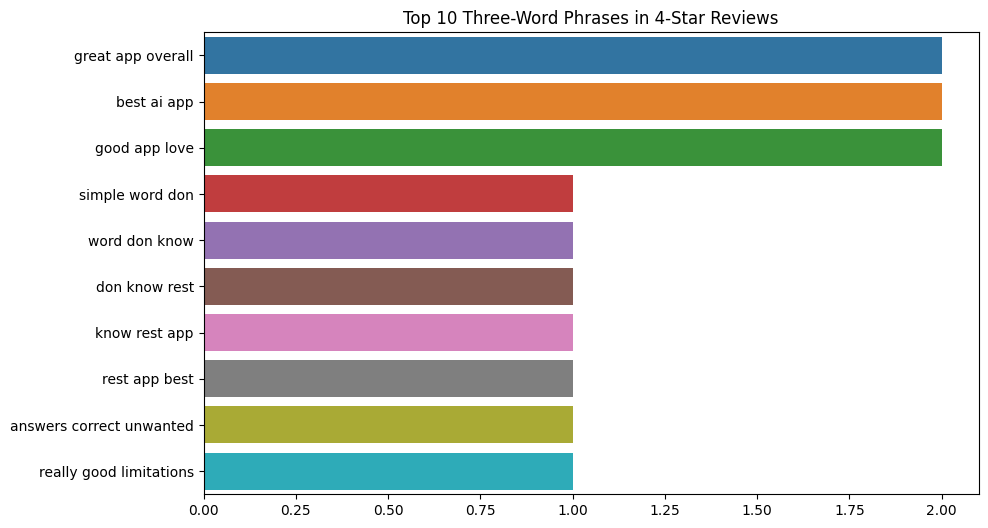

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

four_star_df = df_english[df_english['score'] == 4].copy()
print(f"\nAnalyzing {len(four_star_df)} 4-star reviews.")

# --- 1. Filter for reviews containing suggestion keywords ---
suggestion_keywords = ['but', 'wish', 'however', 'needs', 'if only', 'suggestion']
pattern = '|'.join(suggestion_keywords)

# Create a new DataFrame containing only the reviews with these keywords
suggestions_df = four_star_df[four_star_df['content'].str.contains(pattern, case=False, na=False)].copy()

print(f"Found {len(suggestions_df)} 4-star reviews that likely contain suggestions.")

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

# Top Trigrams (3-word phrases) in 4-star reviews
top_tri_grams = get_top_ngram(suggestions_df['content'], n=3)
x, y = map(list, zip(*top_tri_grams))

plt.figure(figsize=(10, 6))
sns.barplot(x=y, y=x)
plt.title('Top 10 Three-Word Phrases in 4-Star Reviews')
plt.savefig('images/top_tri_gramsbar.png')
plt.show()

In [25]:
# To see the full, untruncated review text
pd.set_option('display.max_colwidth', None)

unwanted_reviews = suggestions_df[
    (suggestions_df['content'].str.contains('great', case=False, na=False)) &
    (suggestions_df['content'].str.contains('app', case=False, na=False)) &
    (suggestions_df['content'].str.contains('overall', case=False, na=False))
]

print(f"Found {len(unwanted_reviews)} reviews containing 'great', 'app', and 'overall':")
for index, row in unwanted_reviews.head(5).iterrows():
    print(f"Date: {row['at'].strftime('%Y-%m-%d')}")
    print(f"Review: {row['content']}")
    print("-" * 60)

Found 3 reviews containing 'great', 'app', and 'overall':
Date: 2025-04-01
Review: it doesn't give much option but a great app overall
------------------------------------------------------------
Date: 2025-04-14
Review: ★★★★☆ ChatGPT is one of the best AI tools I’ve used. It gives helpful and accurate answers most of the time, and I like how friendly and easy it is to talk to. It really feels like chatting with a smart friend. However, sometimes it can get a bit annoying when it adds extra things I didn’t ask for. Still, it’s a great app overall and really useful for learning and fun conversations.
------------------------------------------------------------
Date: 2025-02-26
Review: I've been using the ChatGPT app for a while now and overall, it's been a fantastic tool for everything from casual conversation to solving complex queries. The AI is incredibly helpful, and it provides responses that are informative and relevant to a variety of topics. However, there's a small issue that c

In [26]:
# To see the full, untruncated review text
pd.set_option('display.max_colwidth', None)

unwanted_reviews = suggestions_df[
    (suggestions_df['content'].str.contains('answer', case=False, na=False)) &
    (suggestions_df['content'].str.contains('correct', case=False, na=False)) &
    (suggestions_df['content'].str.contains('unwanted', case=False, na=False))
]

print(f"Found {len(unwanted_reviews)} reviews containing 'answer', 'correct', and 'unwanted':")

for index, row in unwanted_reviews.head(5).iterrows():
    print(f"Date: {row['at'].strftime('%Y-%m-%d')}")
    print(f"Review: {row['content']}")
    print("-" * 60)

Found 1 reviews containing 'answer', 'correct', and 'unwanted':
Date: 2025-06-04
Review: many answers were correct but some unwanted
------------------------------------------------------------


In [27]:
# To see the full, untruncated review text
pd.set_option('display.max_colwidth', None)

unwanted_reviews = suggestions_df[
    (suggestions_df['content'].str.contains('really', case=False, na=False)) &
    (suggestions_df['content'].str.contains('good', case=False, na=False)) &
    (suggestions_df['content'].str.contains('limitations', case=False, na=False))
]

print(f"Found {len(unwanted_reviews)} reviews containing 'really', 'good', and 'limitations':")

for index, row in unwanted_reviews.head(5).iterrows():
    print(f"Date: {row['at'].strftime('%Y-%m-%d')}")
    print(f"Review: {row['content']}")
    print("-" * 60)

Found 1 reviews containing 'really', 'good', and 'limitations':
Date: 2025-01-27
Review: it's really good but it has some limitations
------------------------------------------------------------


Observation:
The causes for minor disatisfactions are diverse, and there aren't common issues that are shared across the board for users with great but not perfect experiences. The nuance of the feedbacks has excellent potential for more advanced NLP analysis.  

## negative topic trending


--- Analyzing: Performance/Slowness Issues ---
Chart saved to images/performanceslowness_issues.png


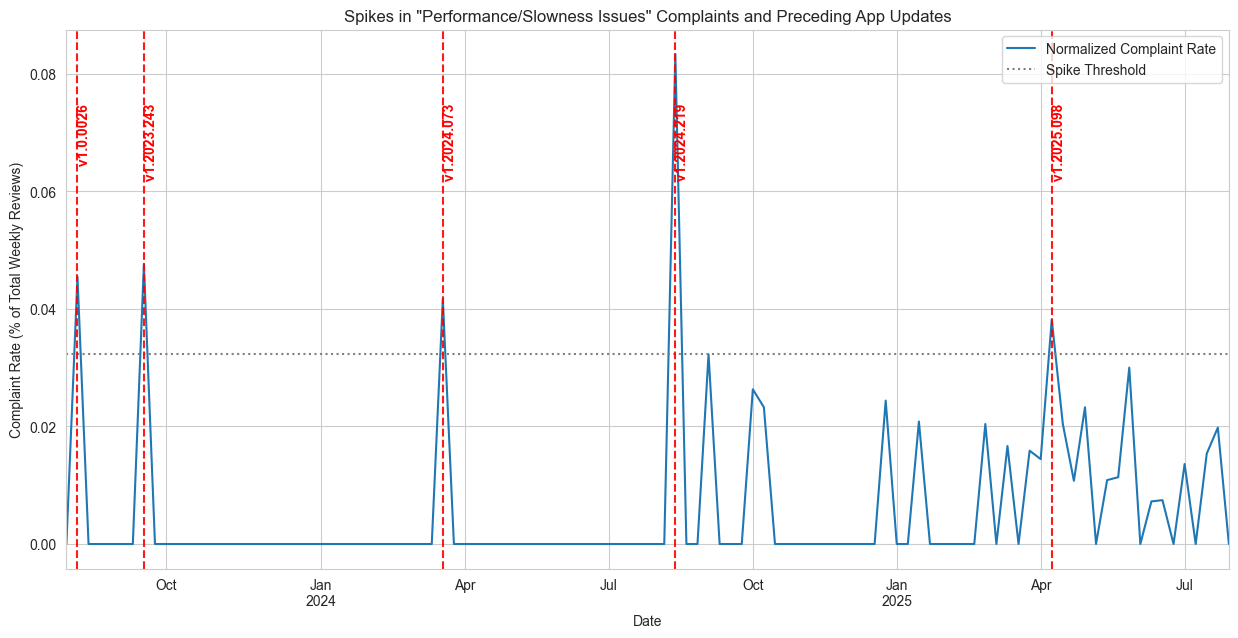


--- Analyzing: Login/Phone Version Issues ---
Chart saved to images/loginphone_version_issues.png


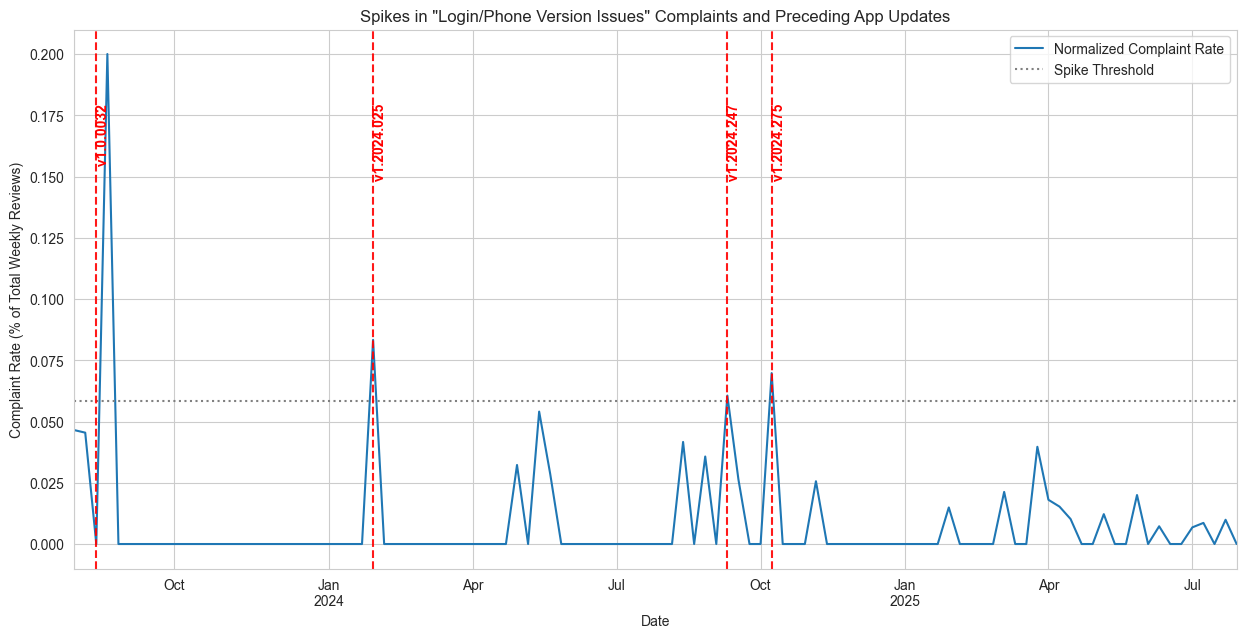


--- Analyzing: Additional Capabilities Issues ---
Chart saved to images/additional_capabilities_issues.png


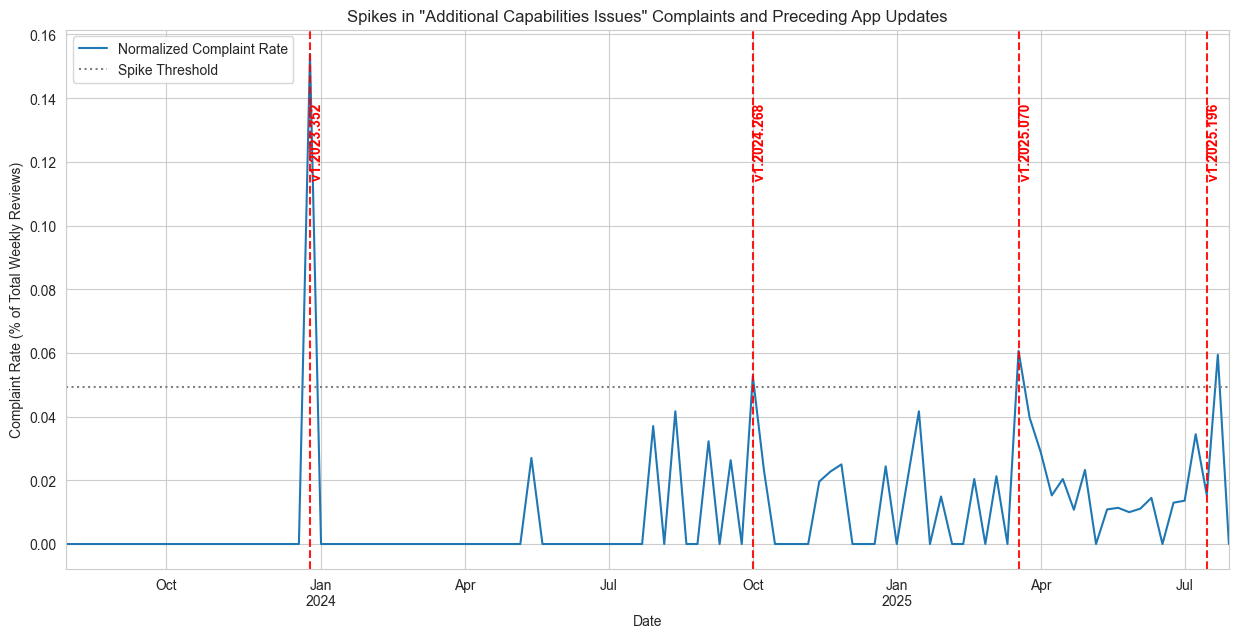


--- Analyzing: Accuracy Issues ---
Chart saved to images/accuracy_issues.png


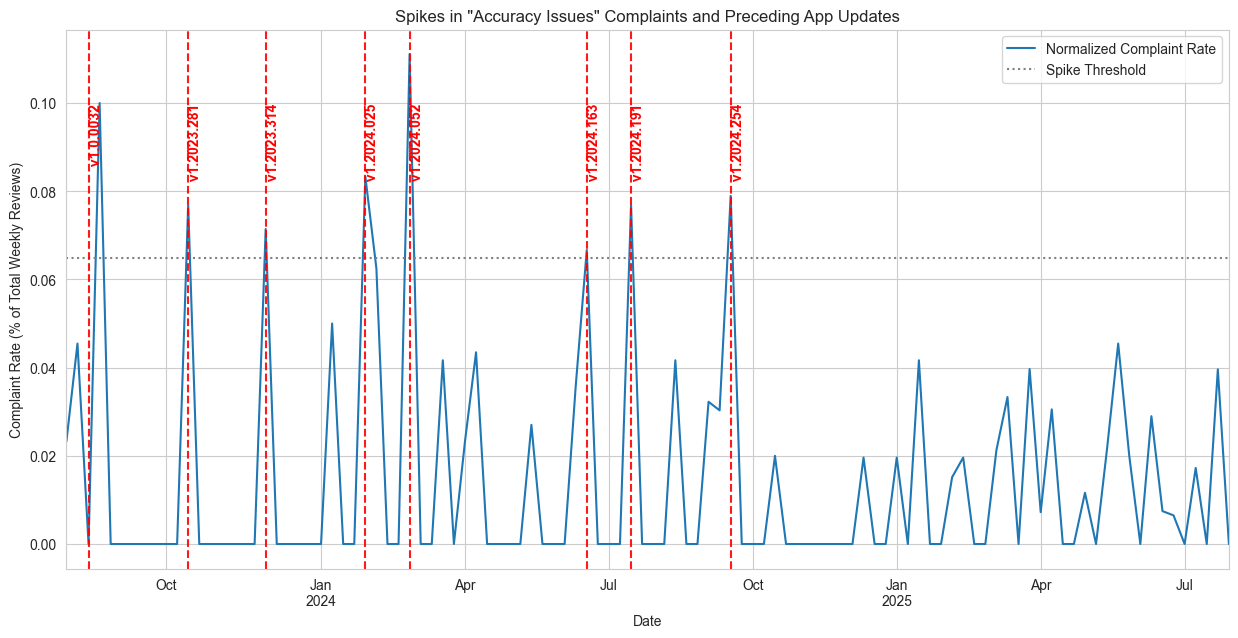


--- Analyzing: Update-Related Issues ---
Chart saved to images/update-related_issues.png


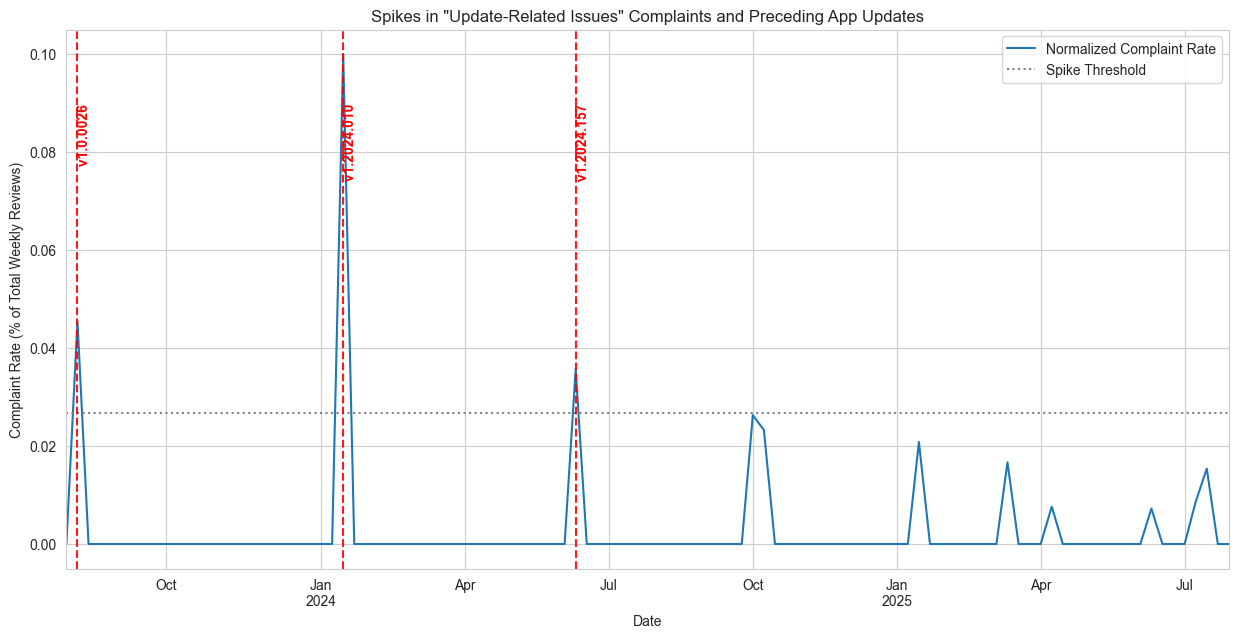

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total reviews over time (we only need to do this once)
total_reviews_over_time = df_english.set_index('at').resample('W').size()
pd.set_option('display.max_colwidth', None)

# Find all unique version release dates (we also only need to do this once)
updates_with_versions = df_english.dropna(subset=['reviewCreatedVersion']).copy()
updates_with_versions.sort_values('at', inplace=True)
all_update_dates = updates_with_versions.drop_duplicates(subset=['reviewCreatedVersion'], keep='first').set_index('reviewCreatedVersion')['at']

# Define Keyword Groups ---
performance_keywords = ['slow', 'lag', 'performance', 'loading', 'freeze', 'crash', 'bug','bugs','speed']
login_keywords = ['login', 'account', 'password', 'signin', 'verify','log in','sign in','authentication','phone']
capabilities_keywords=['video','photo','image','images','photos','videos','voice','audio','upload','file','files']
accuracy_keywords = [ 'error', 'wrong', 'correct', 'fact',  'false', 'incorrect','inaccurate','inaccuracy','errors','confused','confusing']
update_keywords = ['recent update', 'new update','last update','latest update','after update','new version', 'release', 'updated','this version','versions','updates','releases']


keyword_groups = {
    "Performance/Slowness Issues": performance_keywords,
    "Login/Phone Version Issues": login_keywords,
    "Additional Capabilities Issues": capabilities_keywords,
    "Accuracy Issues": accuracy_keywords,
    "Update-Related Issues": update_keywords    
}

sns.set_style("whitegrid")


# --- 3. The Analysis Loop ---

for title, keywords in keyword_groups.items():
    print(f"\n--- Analyzing: {title} ---")
    
    # --- A: Calculate complaint rate for the current topic ---
    pattern = '|'.join(keywords)
    complaints_df = negative_df[negative_df['content'].str.contains(pattern, case=False, na=False)].copy()
    complaints_over_time = complaints_df.set_index('at').resample('W').size()
    normalized_complaints = (complaints_over_time / total_reviews_over_time).fillna(0)

    #if not complaints_df.empty:
        # Display the first 3 examples found
        #print(complaints_df['content'].head(5).to_string(index=False))
    #else:
        #print("No reviews found for this category in the sample.")
    #print("\n")
    
    # --- B: Find spikes and preceding updates for the current topic ---
    spike_threshold = normalized_complaints.mean() + (2 * normalized_complaints.std())
    spike_dates = normalized_complaints[normalized_complaints > spike_threshold]
    
    problematic_updates = {}
    for date, value in spike_dates.items():
        updates_before_spike = all_update_dates[all_update_dates < date]
        if not updates_before_spike.empty:
            most_recent_update_date = updates_before_spike.iloc[-1]
            most_recent_update_version = updates_before_spike.index[-1]
            problematic_updates[most_recent_update_version] = most_recent_update_date
                
    # --- C: Plot the results for the current topic ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 7))
    normalized_complaints.plot(label='Normalized Complaint Rate')

    plt.axhline(y=spike_threshold, color='gray', linestyle=':', label='Spike Threshold')

    # Plot markers ONLY for the suspected problematic updates
    for version, date in problematic_updates.items():
        # --- KEY CHANGE: Use axvline for a vertical line ---
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.9)
        
        plt.text(x=date, y=normalized_complaints.max() * 0.9, s=f' v{version}', rotation=90, verticalalignment='top', color='red', weight='bold')

    # --- D: Use the dynamic title for the plot ---
    plt.title(f'Spikes in "{title}" Complaints and Preceding App Updates')
    plt.xlabel('Date')
    plt.ylabel('Complaint Rate (% of Total Weekly Reviews)')
    plt.legend()
    # Sanitize the title to create a valid filename
    safe_filename = title.lower().replace(' ', '_').replace('/', '') + '.png'
    # Save the figure to the 'images/' folder
    plt.savefig(f"images/{safe_filename}")
    print(f"Chart saved to images/{safe_filename}")
    plt.show()

In [29]:

from utils import analyze_version_by_topic
# (Load your negative_df, all_update_dates, and define your keyword_groups dictionary)

# EXAMPLE: Let's say your chart showed a spike in "Performance Issues" 
# after version '1.2024.219' was released. You can now investigate directly.

analyze_version_by_topic(
    version_string='1.2025.196', 
    topic_name='Additional Capabilities Issues',
    keyword_groups=keyword_groups,
    negative_english_reviews=negative_df, 
    all_update_dates=all_update_dates
)

Detailed look for Version: 1.2025.196 | Topic: Additional Capabilities Issues
Analyzing reviews from 2025-07-19 to 2025-07-27...

Found 5 negative reviews matching the 'Additional Capabilities Issues' topic.

--- Example Complaints for this Topic and Version: ---
Date: 2025-07-21
Review: this app is very dump and stupidity we can't get the images we want this application is useless
------------------------------------------------------------
Date: 2025-07-26
Review: I hate this app I waited for 20 days and he didn't give me my photo generate please improve your stupid chatgpt understand
------------------------------------------------------------
Date: 2025-07-24
Review: chatgpt only gives sugar coated false promises bluffing of actual doing job asking for more n more time. in Actual doing nothing.. totally waste of time.. provides either dummy files or links which doesn't exist not working zip files.. It seems pirated copy of actual AI.. dumb software gives lame excuses like Humans...

Observation: 
    In all of "Performance/Slowness Issues", "Login/Phone Version Issues", "Accuracy Issues" and "Update-Related Issues" charts, the spikes of negative reviews by proportion clearly declined, signaling a successful containment of the issues with newer fixes and updates. The slight growth in "Additional Capabilities Issues" chart also correspond to the rollout of new media features (voice, image), indicating that these new features are a consistent source of user friction. Therefore, the dataset is of high quality for this analysis. 
    
   Overall, this spike-driven analysis proves to be helpful for identifying potentially problematic app versions. The NLP team, in turn, can use these findings to create highly targeted datasets for deeper analysis, sampling reviews from a specific topic within a specific version's release window.  